In [109]:
%config IPCompleter.greedy=True
%matplotlib inline
import string
import numpy as np
import pandas as pd
import scipy
import sklearn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Challenge: Feedback analysis

### Overview of model:

My model works at about 65% accross datasets, which is just a bit better than always guessing `is_positive`, which would yield 51% accuracy.

At this point, my feature engineering is simply listing words with strong positive or negative associations. I didn't spent a ton of time largely because I know this is where NLP really shines.

In [110]:
def print_confusion_matrix(target, y_pred):
    cm = confusion_matrix(target, y_pred)
    positive_percentage = round(cm[1][1]/target.sum(), 2)
    negative_percentage = round(cm[0][0]/((target == False).sum()), 2)
    print(f'\nTrue Positives: {cm[1][1]} ({positive_percentage}) \nTrue Negatives: {cm[0][0]} ({negative_percentage}) \nFalse Positives: {cm[0][1]} \nFalse Negatives: {cm[1][0]}')

In [111]:
def remove_punct(my_str):
    table = str.maketrans(dict.fromkeys(string.punctuation))
    return my_str.translate(table)

def load_and_prep_data(file, keywords, show_chart=True):
    print(f'\n{file}')
    df = pd.read_csv(f'data/{file}.txt', delimiter= '\t', header=None)
    df.columns = ['sentence', 'is_positive']
    df['is_positive'] = (df['is_positive'] == 1)
    df.sentence = df.sentence.apply(remove_punct)

    for key in keywords:
        # Add spaces around the key so that we're getting the word, not just pattern matching.
        df[str(key)] = df.sentence.str.contains(
            str(key),
            case=False
        )
    if show_chart:
        sns.heatmap(df.corr())
        plt.show()
    return df

In [112]:
def create_all_training_datasets(files, keywords):
    training_datasets = {}
    for file in files:
        training_datasets[file] = load_and_prep_data(file, keywords, show_chart=True)
    return training_datasets

In [113]:
def create_and_test_model(df, existing_model=None):
    data = df[keywords]
    target = df['is_positive']
    
    if existing_model:
        bnb = existing_model
    else:
        # Our data is binary / boolean, so we're importing the Bernoulli classifier.
        from sklearn.naive_bayes import BernoulliNB
        bnb = BernoulliNB()

        # Fit our model to the data.
        bnb.fit(data, target)

    # Classify, storing the result in a new variable.
    y_pred = bnb.predict(data)

    # Display our results.
    correct = (target == y_pred).sum()
    total = data.shape[0]
    positive_cases = df['is_positive'].sum()
    print(f'Positive cases: {positive_cases}/{total} ({100.0*positive_cases/total})')
    print(f'Correctly labeled {correct}/{total} points: {100.0*correct/total}%')
    print_confusion_matrix(target, y_pred)
    
    return bnb

In [114]:
def f():
    return 1,2,3

In [115]:
IMDB = 'imdb'
AMAZON = 'amazon'
YELP = 'yelp'
files = [IMDB, AMAZON, YELP]

## Keyword features

In [116]:
# Features:
amazon_pos = ['satisfied', 'would recommend', 'highly recommend']
amazon_neg = ['do not', 'joke', 'low', 'unfortunate', 'mad', 'sad', 'crap']
yelp_pos = ['enjoy', 'delicious', 'nice', 'soon', 'perfect', 'tasty']
yelp_neg = ['sick', 'sad', 'dirty', 'piss', 'expensive', 'rude']
positive_keywords = ['good', 'great', 'love', 'enjoy', 'best', 'incredible', 'wonderful', 'favorite', 'cool',] + amazon_pos + yelp_pos
negative_keywords = ['bad', 'terrible', 'aweful', 'hate', 'worst', 'little', 'lack', 'waste', 'odd',] + amazon_neg + yelp_neg
keywords = positive_keywords + negative_keywords

In [117]:
training_datasets[YELP][['sentence', 'is_positive']].sort_values('is_positive').head()

sentence  is_positive
999  Then as if I hadnt wasted enough of my life th...        False
784  The chains which Im no fan of beat this place ...        False
388                                 This is a disgrace        False
387  This place deserves one star and 90 has to do ...        False
786                         We will not be coming back        False

## Load all training datasets with keywords as features.


imdb



amazon



yelp


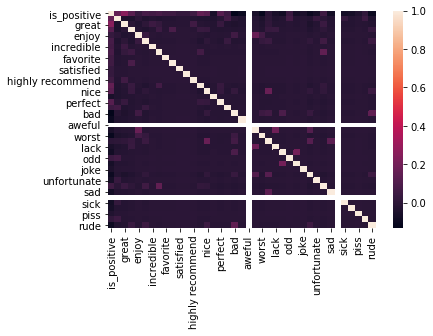

In [118]:
training_datasets = create_all_training_datasets(files, keywords)

## IMDB

In [119]:
imdb_model = create_and_test_model(training_datasets[IMDB])

Positive cases: 386/748 (51.60427807486631)
Correctly labeled 487/748 points: 65.10695187165776%

True Positives: 367 (0.95) 
True Negatives: 120 (0.33) 
False Positives: 242 
False Negatives: 19


## Test IMDB model on other datasets:

In [120]:
for file in files:
    print('\n\n', file)
    create_and_test_model(training_datasets[file], existing_model=imdb_model)



 imdb
Positive cases: 386/748 (51.60427807486631)
Correctly labeled 487/748 points: 65.10695187165776%

True Positives: 367 (0.95) 
True Negatives: 120 (0.33) 
False Positives: 242 
False Negatives: 19


 amazon
Positive cases: 500/1000 (50.0)
Correctly labeled 579/1000 points: 57.9%

True Positives: 486 (0.97) 
True Negatives: 93 (0.19) 
False Positives: 407 
False Negatives: 14


 yelp
Positive cases: 500/1000 (50.0)
Correctly labeled 575/1000 points: 57.5%

True Positives: 491 (0.98) 
True Negatives: 84 (0.17) 
False Positives: 416 
False Negatives: 9


## Status of current IMDB model: *Sensitive, but lacking specificity*

Using the IMDB model fails to identify *negative sentiments* on on all datasets


## ... Amazon and Yelp (trained on themselves) have the opposite problem: *they idenitfy negative cases (specificity), but aren't sensitive to positive cases*

In [121]:
amazon_model = create_and_test_model(training_datasets[AMAZON], existing_model=None)

Positive cases: 500/1000 (50.0)
Correctly labeled 715/1000 points: 71.5%

True Positives: 240 (0.48) 
True Negatives: 475 (0.95) 
False Positives: 25 
False Negatives: 260


In [122]:
yelp_model = create_and_test_model(training_datasets[YELP], existing_model=None)

Positive cases: 500/1000 (50.0)
Correctly labeled 713/1000 points: 71.3%

True Positives: 258 (0.52) 
True Negatives: 455 (0.91) 
False Positives: 45 
False Negatives: 242


# 2.3.5: Iterate Classifier

For five iterations:
- Using the evaluation techniques we've covered here, look at your classifier's performance in more detail. 
- Then go back and iterate by
    - engineering new features, 
    - removing poor features, or 
    - tuning parameters. 

Answer these questions to compare the performance of each:

- Do any of your classifiers seem to overfit?
- Which seem to perform the best? Why?
- Which features seemed to be most impactful to performance?

## Check for Over Fitting via Cross Validation
Cross validation reveals *fairly* stable models, with a few jumps, sometimes as much as 7 or 8 percentage points.

In [123]:
from sklearn.model_selection import cross_val_score
data = training_datasets[YELP]
cross_val_score(yelp_model, data[keywords], data['is_positive'], cv=10)

array([0.64, 0.72, 0.69, 0.77, 0.72, 0.71, 0.71, 0.68, 0.69, 0.75])

In [124]:
data = training_datasets[AMAZON]
cross_val_score(amazon_model, data[keywords], data['is_positive'], cv=10)

array([0.75, 0.75, 0.81, 0.69, 0.73, 0.7 , 0.63, 0.64, 0.72, 0.62])

In [125]:
data = training_datasets[IMDB]
cv = cross_val_score(imdb_model, data[keywords], data['is_positive'], cv=10)
np.around(cv, decimals=2)

array([0.66, 0.67, 0.55, 0.65, 0.67, 0.64, 0.64, 0.62, 0.61, 0.69])

## Just counting most common words isn't too informative...

In [126]:
from collections import Counter
def counter(sentences):
    cnt = Counter()
    for sentence in list(sentences):
        for word in sentence.split(' '):
            cnt[word] += 1
    return cnt

In [127]:
counted_words = counter(training_datasets[IMDB].sentence.str.lower())
counted_words.most_common(50)

[('', 1806),
 ('the', 798),
 ('a', 429),
 ('and', 425),
 ('of', 375),
 ('is', 338),
 ('this', 277),
 ('to', 250),
 ('i', 241),
 ('it', 239),
 ('in', 198),
 ('was', 184),
 ('movie', 177),
 ('film', 155),
 ('that', 153),
 ('for', 104),
 ('as', 93),
 ('with', 90),
 ('but', 83),
 ('its', 81),
 ('one', 75),
 ('are', 75),
 ('on', 74),
 ('not', 72),
 ('you', 72),
 ('bad', 66),
 ('very', 65),
 ('just', 63),
 ('so', 59),
 ('all', 57),
 ('good', 56),
 ('an', 53),
 ('at', 52),
 ('about', 50),
 ('be', 50),
 ('have', 48),
 ('by', 48),
 ('like', 47),
 ('from', 46),
 ('there', 44),
 ('time', 42),
 ('acting', 41),
 ('or', 40),
 ('out', 40),
 ('really', 40),
 ('if', 39),
 ('who', 38),
 ('even', 38),
 ('were', 38),
 ('great', 38)]

# Improving model/assesing points of failure
RECOMMENDATION: go bak and look where you model fails, what kind of stuff is it fialing on?

Common error: negations trip you up "this is NOT a good film" A model could look for negation words.

In [137]:
def _create_and_test_model(df, existing_model=None):
    data = df[keywords]
    target = df['is_positive']
    
    if existing_model:
        bnb = existing_model
    else:
        # Our data is binary / boolean, so we're importing the Bernoulli classifier.
        from sklearn.naive_bayes import BernoulliNB
        bnb = BernoulliNB()

        # Fit our model to the data.
        bnb.fit(data, target)

    # Classify, storing the result in a new variable.
    y_pred = bnb.predict(data)

    # Display our results.
    correct = (target == y_pred).sum()
    total = data.shape[0]
    positive_cases = df['is_positive'].sum()
    print(f'Positive cases: {positive_cases}/{total} ({100.0*positive_cases/total})')
    print(f'Correctly labeled {correct}/{total} points: {100.0*correct/total}%')
    print_confusion_matrix(target, y_pred)
    
    return y_pred



## Inspect false negatives, which Amazon has in spades
ie if it's a negative sentement, we got it. If it's a possitive sentiment, we're missing it

## Likely reason: Positive Sentiments focus on aspects of the product (ie battery life), *not* necessarily emotions or positive words.
Yelp, where I got most of my words, focus on EXTREME emotions and reactions, not more subtle words like "as intended" and "very well"

In [140]:
amazon_df = training_datasets[AMAZON]
y_pred = _create_and_test_model(amazon_df)
pd.options.display.max_colwidth = 2000
amazon_df[(amazon_df['is_positive'] != y_pred) & (amazon_df['is_positive'] == True)]#.sentence

Positive cases: 500/1000 (50.0)
Correctly labeled 715/1000 points: 71.5%

True Positives: 240 (0.48) 
True Negatives: 475 (0.95) 
False Positives: 25 
False Negatives: 260


sentence  \
7                                                                                                  If you are Razr owneryou must have this   
11                                                      He was very impressed when going from the original battery to the extended battery   
23                                                 I have yet to run this new battery below two bars and thats three days without charging   
31                                                                  This product is ideal for people like me whose ears are very sensitive   
34                                 Car charger as well as AC charger are included to make sure you never run out of juiceHighy recommended   
36                                                                                                                It has kept up very well   
44                                                                                                             Excellent bluetooth headset   
45                                                                                                          It has all the features I want   
48                                                                                                               This case seems well made   
52                                    A usable keyboard actually turns a PDA into a realworld useful machine instead of just a neat gadget   
53                                                                This phone is pretty sturdy and Ive never had any large problems with it   
55                                                                             Everything about it is fine and reasonable for the price ie   
58                     I have been very happy with the 510 and have had NO complaints from any one regarding my sound quality on their end   
67                                  It feels more comfortable than most headsets because I wear glasses and that gets in the way sometimes   
74                                                                                                               This is a beautiful phone   
80                                                                                            I wear it everyday and it holds up very well   
82                                                                                     Well packaged arrived on time and works as intended   
88                                                      Product was excellent and works better than the verizon one and Boy was it cheaper   
89                                                                                                                   The phone loads super   
91                                                                                                                        Made very sturdy   
95                                                                                                              Will order from them again   
100                                                                                     Integrated seamlessly with the Motorola RAZR phone   
102                                                                                                                   Definitely a bargain   
110                       Sound quality on both end is excellent I use headset to call my wife and ask my wife to use headset to call me 2   
111                                                                              This phone is slim and light and the display is beautiful   
117                                                                                                      It is very comfortable on the ear   
118                                                                                                            It has been a winner for us   
119                                                                                                        Setup couldnt have been simpler   
120     Ive 

## False positives (were negative emotions, but marked as positive). These were less than 5% of Negatives.

In [144]:
amazon_df[(amazon_df['is_positive'] != y_pred) & (amazon_df['is_positive'] == False)].sentence

30                                                                      This is a simple little phone to use but the breakage is unacceptible
81                                                                                                                         Not a good bargain
84                                                                                  This item worked great but it broke after 6 months of use
90                For a product that costs as much as this one does I expect it to work far better and with greater ease than this thing does
228                                                          I have had this phone for over a year now and I will tell you its not that great
326                                                                          Howeverthe riingtones are not the best and neither are the games
338                                                                It was an inexpensive piece but I would still have expected better quality
355   